In [12]:

import sys
sys.path = ['/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages'] + sys.path
import pickle
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline
from scipy.stats import pearsonr
from lim.genetics import qtl
from lim.genetics.phenotype import NormalPhenotype
import logging
lim_logging = logging.getLogger('lim')
lim_logging.setLevel(logging.CRITICAL)

In [13]:
[X_matrix, y_pheno] = pickle.load(open('../data/processed/associations/all_lung_associations.py','rb'))

In [4]:
print (X_matrix.shape, y_pheno.shape)

(273, 28683) (273, 1024)


In [14]:
filter_limit = 0
shuffle = 0
filtered_indexes = np.mean(X_matrix, axis=0) > filter_limit

f_X_matrix = X_matrix[:,filtered_indexes]
print (f_X_matrix.shape)
np.random.seed(42)
upper_limit = math.floor(f_X_matrix.shape[1] / 100) + 1
p_values = []
f_y_pheno = y_pheno[:,0].copy()
if shuffle == 1:
    random.shuffle(f_y_pheno)
f_y_pheno_obj = NormalPhenotype(f_y_pheno)

(273, 28683)


In [4]:
for i in range(upper_limit):
    sm_X_matrix = f_X_matrix[:, 100*i:100*(i+1)]
    G = sm_X_matrix.copy()
#     print (f_X_matrix.shape, f_y_pheno.shape)

    lrt = qtl.scan(f_y_pheno_obj, sm_X_matrix, G, progress=False)
    p_values.extend(lrt.pvalues())
    if i % 10 == 0:
        print (i)
pickle.dump(p_values, open('../data/processed/associations/all_lung_p_values_{}_{}.py'.format(filter_limit,shuffle),'wb'))

(273, 28683)
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280


In [6]:
real_pvalues = np.array(pickle.load(open('../data/processed/associations/all_lung_p_values_0_0.py','rb')))
shuffled_pvalues = np.array(pickle.load(open('../data/processed/associations/all_lung_p_values_0_1.py','rb')))

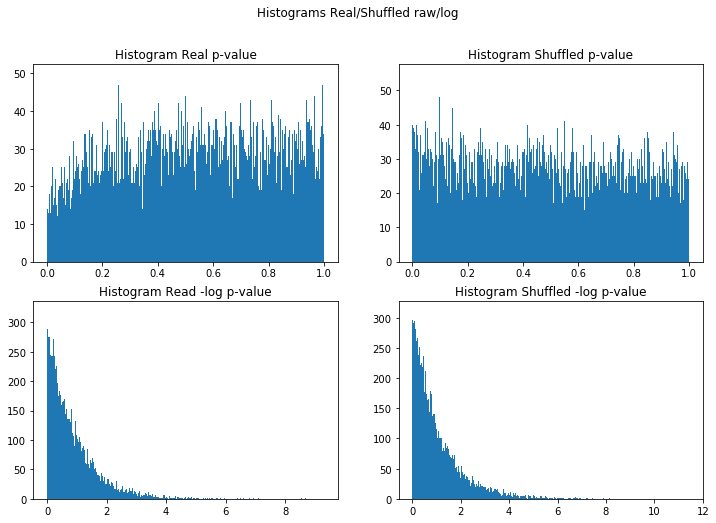

In [15]:
f,a = plt.subplots(2,2, figsize=(12,8))
f.suptitle("Histograms Real/Shuffled raw/log")
a[0][0].set_title("Histogram Real p-value")
a[0][0].hist([x for x in real_pvalues],bins=1000)
a[0][1].set_title("Histogram Shuffled p-value")
a[0][1].hist([x for x in shuffled_pvalues],bins=1000)
a[1][0].set_title("Histogram Read -log p-value")
a[1][0].hist([-math.log(x) for x in real_pvalues],bins=1000)
a[1][1].set_title("Histogram Shuffled -log p-value")
a[1][1].hist([-math.log(x) for x in shuffled_pvalues],bins=1000)
plt.show()

In [20]:
min(real_pvalues)

9.163716132897003e-05

In [17]:
real_min_idx = np.argmin(real_pvalues)

In [18]:
real_min_idx

10588

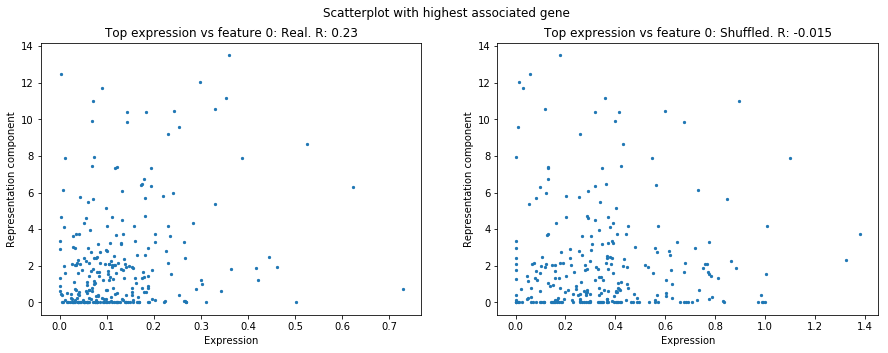

In [17]:
f,a = plt.subplots(1,2, figsize=(15,5))
f.suptitle("Scatterplot with highest associated gene")
real_min_idx = np.argmin(real_pvalues)
real_R = '{0:.2}'.format(pearsonr(X_matrix[:,real_min_idx], y_pheno[:,0])[0])
a[0].scatter(X_matrix[:,real_min_idx], y_pheno[:,0], s=5)
a[0].set_ylabel('Representation component')
a[0].set_xlabel('Expression')
a[0].set_title("Top expression vs feature 0: Real. R: {}".format(real_R))
shuffle_min_idx = np.argmin(shuffled_pvalues)
shuffle_R = '{0:.2}'.format(pearsonr(X_matrix[:,shuffle_min_idx], f_y_pheno)[0])
a[1].set_title("Top expression vs feature 0: Shuffled. R: {}".format(shuffle_R))
a[1].set_ylabel('Representation component')
a[1].set_xlabel('Expression')
a[1].scatter(X_matrix[:,shuffle_min_idx], f_y_pheno, s=5)

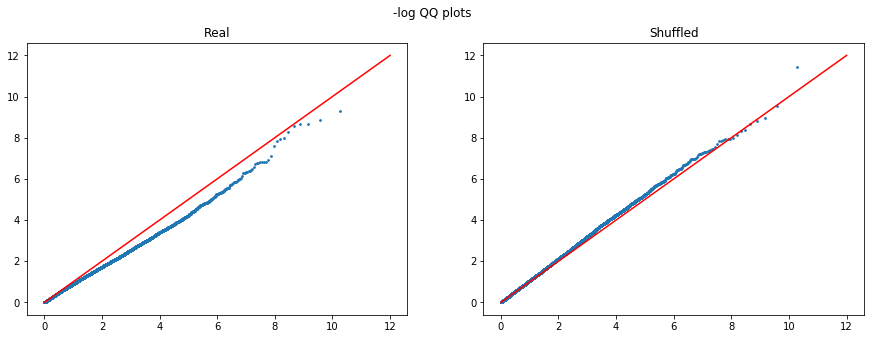

In [18]:
sorted_real_indexes = np.argsort(real_pvalues)
sorted_real_pvalues = real_pvalues[sorted_real_indexes]
sorted_shuffled_indexes = np.argsort(shuffled_pvalues)
sorted_shuffled_pvalues = shuffled_pvalues[sorted_shuffled_indexes]


sample_real = sorted_real_pvalues
expected_real = np.linspace(1/len(sorted_real_pvalues), 1, len(sorted_real_pvalues))
sample_shuffle = sorted_shuffled_pvalues
expected_shuffle = np.linspace(1/len(sorted_shuffled_pvalues), 1, len(sorted_shuffled_pvalues))

f,a = plt.subplots(1,2, figsize=(15,5))
f.suptitle('-log QQ plots')
a[0].scatter([-math.log(x) for x in expected_real], [-math.log(x) for x in sample_real], s=3)
a[0].plot(np.linspace(0,12,100), np.linspace(0,12,100),c='red')
a[0].set_title('Real')
a[1].scatter([-math.log(x) for x in expected_shuffle], [-math.log(x) for x in sample_shuffle], s=3)
a[1].plot(np.linspace(0,12,100), np.linspace(0,12,100),c='red')
a[1].set_title('Shuffled')
